In [1]:
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

CLIGHT = 299792458 #speed of light in [m/s]
TSUN = 4.9169e-6 #mass of sun in [s]
PC = 3.0856775807e16 #parsecs in [s]


## Marginalize over Gaia distance measurements
+ Get chirp mass from frequency and amplitude
+ Use chirp mass to separate GR and astrophysical contributions to Pdot

See [spreadsheet](https://docs.google.com/spreadsheets/d/1PfwgaPjOpcEz_8RIcf87doyhErnT0cYTYJ9b6fC0yfA/edit#gid=0) for data and references

In [2]:
#GAIA distances and 1-sigma errors to loudest binaries.

distances={}

distances['hplib']={}
distances['hplib']['parallax']=3.622
distances['hplib']['parallax_sigma']=0.052

distances['sdssj1908']={}
distances['sdssj1908']['parallax']=0.954
distances['sdssj1908']['parallax_sigma']=0.046



## Color maps

In [3]:
outgoing_colors = ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#a50f15','#67000d']
incoming_colors = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']

## Compare EM-constrained PE over time

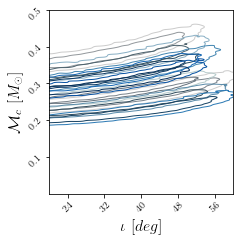

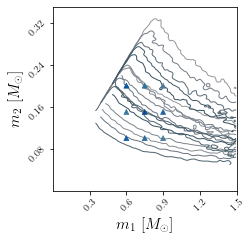

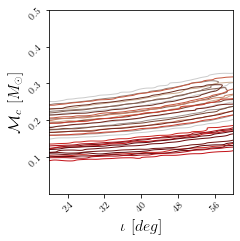

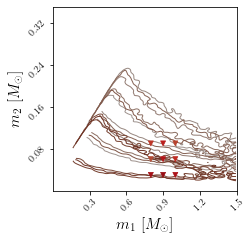

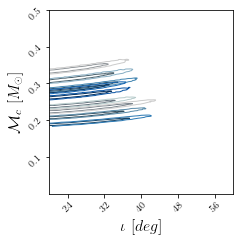

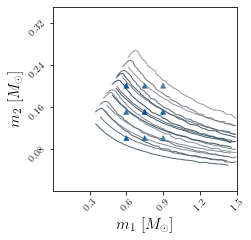

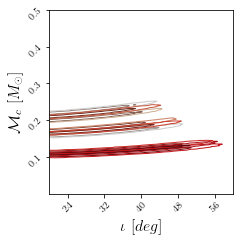

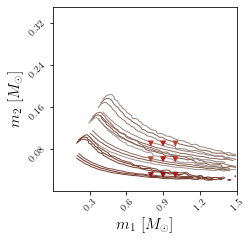

In [5]:
#Pick a source [amcvn, hplib, sdssj1908]
#for source in ['sdssj1908','hplib']:
for source in ['sdssj1908','hplib']:


    #Pick a Tobs [04yr, 08yr]
    for T in ['08yr']:


        for direction in ['ingoing','outgoing']:

            #Get chain files from catalog directory
            filenames = glob.glob(source+ "/" + direction + "/" + "*" + "/" + T + "/catalog_1/*chain.dat") 

            #Use only a subset of the parameters for plotting
            parameters_LISA = ['$\iota\ [deg]$','$\mathcal{M}_c\ [M_\odot]$']#,'$\dot{P}_{GR}$','$\dot{P}_{astro}$']
            parameters_m1m2 = ['$m_1\ [M_\odot]$','$m_2\ [M_\odot]$']


            #Get parallax info from dictionary, convert to arcsec
            parallax_mean = distances[source]['parallax']/1000
            parallax_sigma = distances[source]['parallax_sigma']/1000

            
            c_LISA=ChainConsumer()
            c_m1m2=ChainConsumer()

            index=0

            incoming_index = 0
            outgoing_index = 0

            #loop over chains
            for file in filenames:

                #parse the directory name into human-readable key
                dir_name = file.split('/')[2]
                m1_name = dir_name.split('-')[0]
                m2_name = dir_name.split('-')[1]
                chain_name = 'm1='+m1_name+', m2='+m2_name

                #parse the directory name into incoming or outgoing
                direction = file.split('/')[1]
                if direction == 'ingoing':
                    color = incoming_colors[incoming_index]
                    incoming_index = incoming_index+1
                else:
                    color = outgoing_colors[outgoing_index]
                    outgoing_index = outgoing_index+1

                #parse chain files
                chain=np.loadtxt(filenames[index], usecols=(0,1,2,5))

                N = np.size(chain,0)
                Mc = np.empty([N])
                m1 = np.empty([N])
                m2 = np.empty([N])
                fdot_GR = np.empty([N])
                fdot_astro = np.empty([N])
                inc = np.empty([N])
                postchain_LISA = np.empty([N,2])
                postchain_m1m2 = np.empty([N,2])


                #Looping over chain samples, convert from f0,dfdt,A,cosinc[rad] -> Mc,P,Pdot_astro,Pdot_GR,inc[deg],m1,m2
                for n in range(0,N):
                    f0 = chain[n,0]
                    dfdt=chain[n,1]
                    A = chain[n,2]

                    #Get distance: Draw from N[parallax,parallax_sigma], rejection sample dL<0
                    while True:
                        dL = (1./(np.random.normal(parallax_mean,parallax_sigma,1))) * (PC/CLIGHT)
                        if dL>0:
                            break

                    #convert inclination to degrees
                    inc[n]=np.arccos(chain[n,3])*180./np.pi

                    #Convert A,f,dL into Mc and fdots
                    Mc[n] = ((dL*A/(2*(np.pi*f0)**(2./3.)))**(3./5.))/TSUN
                    fdot_GR[n] = (96./5.) * (np.pi**8. * (Mc[n]*TSUN)**5 * f0**11)**(1./3.)
                    fdot_astro[n] = dfdt - fdot_GR[n]

                    #Get masses: Draw from U[qmin,qmax], rejection sample on out-of-bounds masses
                    qmin=0.01
                    qmax=0.4
                    while True:
                        while True:
                            m1draw = np.random.uniform(0,1)
                            m2draw = np.random.uniform(0,1)
                            q = m2draw/m1draw
                            if q>qmin and q<qmax:
                                break
                        #q = np.random.uniform(qmin,qmax)
                        eta = q/(1+q)**2
                        M = Mc[n]*(eta**(-3./5.))
                        m2[n] = (M/2.)*(1. - np.sqrt(1. - 4.*eta))
                        m1[n] = M - m2[n]
                        if m1[n]<1.5 and m2[n]>.01:
                            break


                    #Convert fdots to Pdots
                    P = 2./f0
                    fdot_GR[n] = fdot_GR[n]*(P**2)/(-2.0)
                    fdot_astro[n] = fdot_astro[n]*(P**2)/(-2.0)

                    #Store post-production parameters into chain array for chainConsumer 
                    postchain_LISA[n] = [inc[n],Mc[n]]#,fdot_GR[n],fdot_astro[n]]
                    postchain_m1m2[n] = [m1[n],m2[n]]



                #c_m1m2.add_chain(postchain_m1m2,parameters=parameters_m1m2,name=chain_name)
                c_m1m2.add_chain(postchain_m1m2,parameters=parameters_m1m2,name='')#,color=color)
                #c_LISA.add_chain(postchain_LISA,parameters=parameters_LISA,name=chain_name,color=color)
                c_LISA.add_chain(postchain_LISA,parameters=parameters_LISA,name='')#,color=color)


                index = index+1

            #parse directory names to get injected values (would be cleaner to grab injection parameters)
            incoming_index = 0
            outgoing_index = 0


            for file in filenames:
                chain_name = file.split('/')[2]
                truth = [float(x) for x in chain_name.split('-')]

                #set marker style depending on ingoing or outgoing AMCVn
                if direction == 'ingoing':
                    marker = "^"
                else:
                    marker = "v"

                c_m1m2.add_marker(truth,name='',parameters=parameters_m1m2, marker_style=marker, marker_size=25)#,color=color)
                #c_m1m2.add_marker([0.6,0.9],name='',parameters=parameters_m1m2)


            if direction == 'ingoing':
                cmap = "Blues"
            else:
                cmap = "Reds"

            #Plot em!
            c_LISA.configure(cloud=False,plot_hists=False,sigmas=[0,1,2],tick_font_size=10,label_font_size=16,legend_kwargs={"fontsize":16},cmap=cmap)
            fig = c_LISA.plotter.plot(filename=source+'_'+direction+'_'+T+'_LISA.png',extents=[(20,60),(0,0.5)],figsize=1.0)
            #fig=c_LISA.plotter.plot_distributions()

            c_m1m2.configure(cloud=False,plot_hists=False,sigmas=[0,2],tick_font_size=10,label_font_size=16,legend_kwargs={"fontsize":16},cmap=cmap)
            fig = c_m1m2.plotter.plot(filename=source+'_'+direction+'_'+T+'_m1m2.png',extents=[(0,1.5),(0,0.35)],figsize=1.0)